# 1. Data PreProcessing

In this notebook, I parse through my list of acquired midi files to extract notes and chords and convert them to LSTM friendly inputs.

In [1]:
! pip install music21
! pip install np_utils
! pip install pygame

In [2]:
import glob
import pickle
import numpy as np
import pandas as pd
from music21 import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Flatten
from keras.layers import Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D
from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
import pydot
import tensorflow as tf
from pygame import *

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


**In the cell below, I load each file into a Music21 stream object using the converter.parse(file) function, outputting a list of each note and chord and each jazz song. I append the pitch of every note and chord into a sequential list, which will serve as an input to my network**

In [28]:
#creating an empty list to hold the notes in
notes = []
durations = []

#this for loop goes through each midi file and flattens out the notes inside of it
for file in glob.glob("/Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/*.mid"): 
    midi = converter.parse(file)

    print("Parsing %s" % file)

    notes_to_parse = None

    try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi) #Change to only grab the piano parts
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes


    for element in notes_to_parse:
        if isinstance(element, note.Note): #if it's a single note, we don't have to join it to any other notes in the series 
            notes.append(str(element.pitch) + " " +  str(element.quarterLength))
        elif isinstance(element, chord.Chord): #if it's a chord, we will have to join it to the other notes
            notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
        elif isinstance(element, note.Rest):
            notes.append(str(element.name)  + " " + str(element.quarterLength))


Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/dearlybeloved.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/IfIwere.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/broadway.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/Falling in Love with Love trio.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/Waltse For Dave.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/Day Dream.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/MyFoolishHeart.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/something wonderful.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/By The Time.mid
Parsing /U

Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/justfrien solo.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/The Way You look trio.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/Recardo.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/couldwrite.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/Cantabile 2.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/NewOrleans.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/BrazilianSuite.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/thereisnogreaterlove.mid
Parsing /Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/pure_jazz_samples/AllTheThings V2.mid
Parsing /Users

In [29]:
notes

['rest 8.0',
 'rest 8.0',
 'rest 8.0',
 'rest 8.0',
 'rest 25.0',
 'rest 7.75',
 'rest 14.0',
 'rest 8.0',
 'rest 206/3',
 'rest 4.0',
 'rest 35/3',
 'G#2 0.25',
 'G#2 0.5',
 'G#2 0.5',
 'G#2 0.5',
 'G#2 0.5',
 'G#2 0.5',
 'C2 0.0',
 'rest 1/3',
 'C2 1/3',
 'rest 43/6',
 'G#2 0.5',
 'G#2 0.5',
 'B-2 0.0',
 'G#2 1/3',
 'G#2 0.5',
 'C2 0.0',
 'rest 3.0',
 'G#2 0.5',
 'C2 0.0',
 'rest 25/6',
 'B-2 0.25',
 'G#2 1/3',
 'C2 0.0',
 'rest 1.0',
 'G#2 1/3',
 'C2 0.25',
 'rest 1/12',
 'C2 0.5',
 'rest 31/6',
 'G#2 1/3',
 'G#2 0.5',
 'G#2 0.5',
 'C2 0.0',
 'rest 1.0',
 'C2 0.25',
 'rest 0.75',
 'G#2 0.5',
 'C2 0.0',
 'rest 1/3',
 'E-3 0.25',
 'rest 29/12',
 'G#2 1/3',
 'C2 0.0',
 'rest 1/3',
 'G#2 2/3',
 'C2 0.0',
 'rest 11/3',
 'G#2 0.5',
 'C2 0.0',
 'rest 1/3',
 'B-2 1/3',
 'E-3 0.5',
 'rest 31/6',
 'G#2 1/3',
 'G#2 1/3',
 'C2 0.0',
 'rest 3.0',
 'G#2 1/3',
 'G#2 1/3',
 'C2 0.0',
 'rest 1/3',
 'B-2 0.25',
 'rest 29/12',
 'G#2 0.5',
 'C2 0.25',
 'rest 1/12',
 'G#2 1/3',
 'B-2 0.25',
 'rest 53/12

Now that I have my notes, I need to create a mapping function to map from string-based categorical data (notes) to a more neural network friendly integer-based numerical data. I also need to create the network input and output sequences, which are defined as follows:
Network Input: sequences of a defined number of notes in our list of notes
Network Output: The first note or chord that comes after the network input sequence

I defined my sequence length to be 50 notes/chords, meaning that to predict the next note in the sequence, the network uses the previous 50 notes/chords to make the prediction.

In [5]:
#this is the amount of previous notes our algorithm will use to predict the next notes

sequence_length = 50

# get all pitch names
pitchnames = sorted(set(item for item in notes))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    
    
#reshape the input vector into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

#normalizing the input values
n_vocab = len(set(notes))
network_input = network_input / float(n_vocab)

#one-hot encode the output
network_output = np_utils.to_categorical(network_output)

In [6]:
note_to_int

{'0': 0,
 '0.1.3.5.8': 1,
 '0.1.5.8': 2,
 '0.2': 3,
 '0.2.3.5.7': 4,
 '0.2.3.7': 5,
 '0.2.4': 6,
 '0.2.4.7': 7,
 '0.2.4.7.9': 8,
 '0.2.5': 9,
 '0.2.6': 10,
 '0.2.7': 11,
 '0.3': 12,
 '0.3.5': 13,
 '0.3.5.7': 14,
 '0.3.5.7.8': 15,
 '0.3.5.8': 16,
 '0.3.6': 17,
 '0.3.7': 18,
 '0.4': 19,
 '0.4.5.7': 20,
 '0.4.6': 21,
 '0.4.7': 22,
 '0.5': 23,
 '1': 24,
 '1.2': 25,
 '1.2.4': 26,
 '1.2.4.6.9': 27,
 '1.2.6': 28,
 '1.2.6.9': 29,
 '1.3': 30,
 '1.3.6': 31,
 '1.3.6.9': 32,
 '1.3.7': 33,
 '1.3.8': 34,
 '1.4': 35,
 '1.4.6': 36,
 '1.4.6.8': 37,
 '1.4.6.8.9': 38,
 '1.4.6.9': 39,
 '1.4.7': 40,
 '1.4.8': 41,
 '1.5': 42,
 '1.5.6.8': 43,
 '1.5.8': 44,
 '1.6': 45,
 '1.7': 46,
 '10': 47,
 '10.0': 48,
 '10.0.2.3': 49,
 '10.0.2.5': 50,
 '10.0.2.5.7': 51,
 '10.0.3': 52,
 '10.0.4': 53,
 '10.0.5': 54,
 '10.1': 55,
 '10.1.3.5.6': 56,
 '10.1.3.6': 57,
 '10.1.4': 58,
 '10.1.5': 59,
 '10.11.3': 60,
 '10.11.3.6': 61,
 '10.2': 62,
 '10.2.3.5': 63,
 '10.2.5': 64,
 '10.3': 65,
 '11': 66,
 '11.0': 67,
 '11.0.4': 68,
 '

Everything looks good. Time to model.

# 2. Modelling

I played around with a lot of different architectures for my model before finally settling on this one as this one had the best sounding generated samples. 

For this model, I used the following layers: Bidirectional LSTM → Attention → LSTM. The second layer of LSTM was intentionally not Bidirectional. I decided to choose these layers because I thought that after the LSTM and Attention initially made connections with understanding the data, it needed another layer to further develop the ideas it discovered before going to the Dense layers. The loss for this model went down the fastest of any of the models.

In [7]:
""" create the structure of the neural network """
model = Sequential()
model.add(Bidirectional(LSTM(512,
    input_shape=(network_input.shape[1], network_input.shape[2]), 
    return_sequences=True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(0.3))

model.add(LSTM(512,return_sequences=True))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D()) 
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 20, 1024)          2105344   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 512)         3147776   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 350)              

Saving weights of the model as checkpoints so I don't have to wait for the model to finish training to get my weights.

In [21]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

model.fit(network_input, network_output, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
51/51 [==============================] - 114s 2s/step - loss: 4.9764
Epoch 2/20
51/51 [==============================] - 129s 3s/step - loss: 4.8886
Epoch 3/20
51/51 [==============================] - 127s 2s/step - loss: 4.8629
Epoch 4/20
51/51 [==============================] - 141s 3s/step - loss: 4.8491
Epoch 5/20
51/51 [==============================] - 122s 2s/step - loss: 4.8660
Epoch 6/20
51/51 [==============================] - 146s 3s/step - loss: 4.8206
Epoch 7/20
51/51 [==============================] - 156s 3s/step - loss: 4.8056
Epoch 8/20
51/51 [==============================] - 104s 2s/step - loss: 4.7894
Epoch 9/20
51/51 [==============================] - 66s 1s/step - loss: 4.7652
Epoch 10/20
51/51 [==============================] - 115s 2s/step - loss: 4.7483
Epoch 11/20
51/51 [==============================] - 89s 2s/step - loss: 4.7278
Epoch 12/20
51/51 [==============================] - 73s 1s/step - loss: 4.7138
Epoch 13/20
51/51 [=====================

# 3. Generation

To use the neural network, I'll have to put it in the same state as before. This time, I'll load the weights that I saved during training.

In [23]:
""" create the structure of the neural network """
model = Sequential()

model.add(Bidirectional(LSTM(512,return_sequences=True),input_shape=(network_input.shape[1], network_input.shape[2]))) #n_time_steps, n_features? Needed input_shape in first layer, which is Bid not LSTM
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(0.3))

model.add(LSTM(512,return_sequences=True))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D()) #Supposedly needed to fix stuff before dense layer
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Load the weights to each node
model.load_weights('weights-improvement-20-4.6260-bigger.hdf5')

For each note that I want to generate,I submit a sequence to the network. The first sequence I submit is the sequence of notes at the starting index. For every subsequent sequence that I use as input, I will remove the first note of the sequence and insert the output of the previous iteration at the end of the sequence.

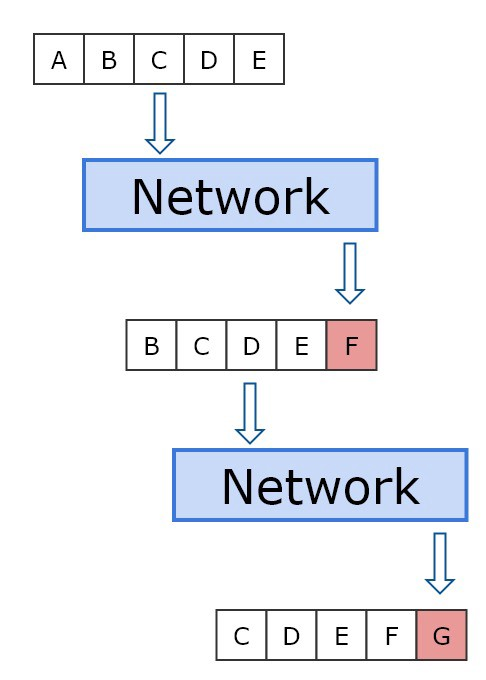



To determine the most likely prediction from the output from the network, I extract the index of the highest value. The value at index X in the output array correspond to the probability that X is the next note. Then I collect all the outputs from the network into a single array.

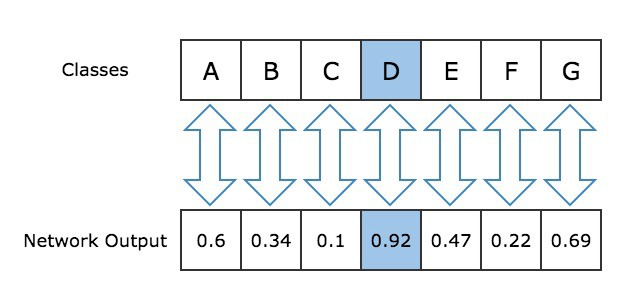


In [24]:
#choosing random index as my starting point, allows us to get different results everytime
start = np.random.randint(0, len(network_input)-1) 

#create mapping funciton to decode output of network and map numerical data back to categorical data
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input[start]

prediction_output = []

for note_index in range(200): #here, we're generating 200 notes
    
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    
    
    prediction = model.predict(prediction_input, verbose=0)

    #get index of note with highest probability that comes after this sequence
    index = np.argmax(prediction)

    #map index back to note
    result = int_to_note[index]
    
    #add predicted note to my output
    prediction_output.append(result)
    
    #insert index of new note to the end of my pattern
    pattern = np.append(pattern,index)
    
    #Remove the first note of my pattern
    pattern = pattern[1:len(pattern)]

Now that I have all the encoded representations of the notes and chords in an array, I can start decoding them and creating an array of Note and Chord objects.

First, I have to determine whether the output is a note or chord.

If the pattern is a chord, I split the string into an array of notes, then loop through the string of each note and create a note object for each. Then, I can create a chord object containing each note.

If the pattern is a note, I create a note object using string representation of the pitch.

At the end of each iteration, I increase offset by 0.5 so notes don't all play at once.

In [26]:
offset = 0
output_notes = []

for pattern in prediction_output:
    #chords!
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = [] #creating the array where we'll store the note values, which the for loop below will handle
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes) #adding the note to the chord object
        new_chord.offset = offset #connecting it to the offset variable
        output_notes.append(new_chord) #adding it to the song
    #notes!
    else:
        new_note = note.Note(pattern) #storing it in the object
        new_note.offset = offset #connecting it to our offset command later on
        new_note.storedInstrument = instrument.Piano() #playing it with piano
        output_notes.append(new_note) #adding it to the song
    #make sure notes don't end up on top of each other by adding an 0.5 offset every time
    offset += 0.5

Now that I have a list of notes and chords generated by the network, I use a music21 toolkit to write the stream object into a midi file.

In [20]:
s = stream.Stream(output_notes)
mf = s.write('midi', fp="/Users/isaacnwang/desktop/Metis_Projects/Project_5/LofiGenerator/final_sample.mid")

#from here, i opened the instrumental and the drum loop file in audacity and played them together!